In [1]:
import json
import pandas as pd
import urllib

In [2]:
# READ THE EMISSIONS DATASET
#  KEEP ONE ROW ONLY PER LA FOR EASIER DATA PROCESSING

df_emissions=pd.read_csv("./uk-local-authority-ghg-emissions-2020-dataset.csv")
df_emissions = df_emissions.drop_duplicates(subset=["Local Authority"], keep="last")#[["Local Authority Code", "Region", "Local Authority", "Area (km2)", "Mid-year Population (thousands)", "Calendar Year"]];
df_emissions.drop(df_emissions[df_emissions["Region"]=="London"].index, inplace=True);
df_emissions = df_emissions.sort_values(["Local Authority Code", "Calendar Year", "Area (km2)"])
df_emissions

,Country,Country Code,Region,Region Code,Second Tier Authority,Local Authority,Local Authority Code,Calendar Year,LA GHG Sector,LA GHG Sub-sector,Greenhouse gas,Territorial emissions (kt CO2e),CO2 emissions within the scope of influence of LAs (kt CO2e),Mid-year Population (thousands),Area (km2)
143981,England,E92000001,North East,E12000001,Hartlepool,Hartlepool,E06000001,2020,Waste management,Waste management 'Other',N2O,1.951778,0.0,93.836,98.3466
145182,England,E92000001,North East,E12000001,Middlesbrough,Middlesbrough,E06000002,2020,Waste management,Waste management 'Other',N2O,1.980158,0.0,141.285,54.5537
150230,England,E92000001,North East,E12000001,Redcar and Cleveland,Redcar and Cleveland,E06000003,2020,Waste management,Waste management 'Other',N2O,2.076715,0.0,137.228,253.7857
152689,England,E92000001,North East,E12000001,Stockton-on-Tees,Stockton-on-Tees,E06000004,2020,Waste management,Waste management 'Other',N2O,10.555841,0.0,197.419,209.7309
140186,England,E92000001,North East,E12000001,Darlington,Darlington,E06000005,2020,Waste management,Waste management 'Other',N2O,1.737039,0.0,107.402,197.4758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464874,Wales,W92000004,Wales,W92000004,Wales,Torfaen,W06000020,2020,Waste management,Waste management 'Other',N2O,1.530829,0.0,94.832,126.2401
455912,Wales,W92000004,Wales,W92000004,Wales,Monmouthshire,W06000021,2020,Waste management,Waste management 'Other',N2O,1.732467,0.0,95.164,886.0557
458468,Wales,W92000004,Wales,W92000004,Wales,Newport,W06000022,2020,Waste management,Waste management 'Other',N2O,2.528651,0.0,156.447,217.4554
461014,Wales,W92000004,Wales,W92000004,Wales,Powys,W06000023,2020,Waste management,Waste management 'Other',N2O,2.373984,0.0,133.030,5195.4561


In [3]:
# READ ROAD LENGTHS DATASET

df_roads = pd.read_csv("./rdl0202.csv", skiprows=6)
df_roads = df_roads[["ONS Area \nCode", "Region", "Local Authority", "All 'A' roads", "Total road length "]]
df_roads.drop(df_roads[df_roads["Region"]=="London"].index, inplace=True);
df_roads=df_roads.sort_values(["ONS Area \nCode"])
#df_roads

In [4]:
merged_df = pd.merge(df_emissions[["Local Authority Code", "Local Authority", "Region", "Area (km2)"]], df_roads[["ONS Area \nCode","Local Authority", "All 'A' roads", "Total road length "]], left_on="Local Authority Code", right_on="ONS Area \nCode", how="inner")
merged_df = merged_df.sort_values(["Area (km2)", "Local Authority Code"])
#merged_df

In [5]:
with open("la_countsite_dict.json") as dictionary_json:
    la_countsites=json.load(dictionary_json)

In [6]:
from tqdm import tqdm

START_DATE = "01012017"
END_DATE = "01012020"

for key, value in tqdm(la_countsites.items()):
    for site in value:
        site_id = site["Id"]
        url_text = f"https://webtris.highwaysengland.co.uk/api/v1/quality/overall?sites={site_id}&start_date={START_DATE}&end_date={END_DATE}"
        with urllib.request.urlopen(url_text) as url:
            site_report = json.loads(url.read().decode())
        site["Quality"] = site_report["data_quality"]

100%|██████████| 361/361 [08:48<00:00,  1.46s/it] 


In [7]:
THRESHOLD = 90

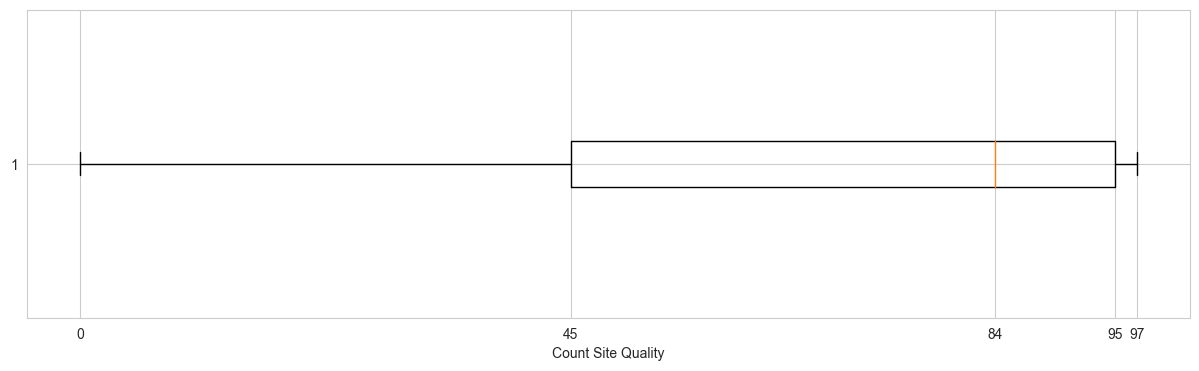

In [8]:
# Analysis of quality distribution of countsites
import matplotlib.pyplot as plt
import numpy as np

sites = [site["Quality"] for sites_list in la_countsites.values() for site in sites_list]

fig = plt.figure(1, figsize=(15, 4))
ax = fig.add_subplot(111)

ax.boxplot(sites, vert=False, manage_ticks=True)
ax.set_xlabel('Count Site Quality')

quantiles = np.quantile(sites, np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.5, zorder=0)
ax.set_ylim(0.5, 1.5)
ax.set_xticks(quantiles)
plt.show()

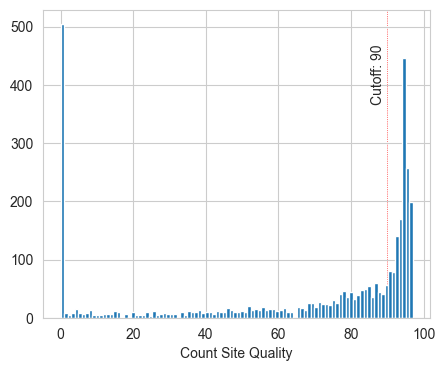

In [9]:
fig = plt.figure(1, figsize=(5, 4))
ax = fig.add_subplot(111)

ax.hist(sites, bins=100)
ax.set_xlabel('Count Site Quality')

ax.axvline(90, color='red', ls=':', lw=0.5, zorder=0)
ax.text(THRESHOLD*0.95, plt.ylim()[1]*0.7, 'Cutoff: {}'.format(THRESHOLD), rotation="vertical")
plt.show()

In [10]:
la_quality_countsites = {}
for la, sites in la_countsites.items():
    la_quality_countsites[la] = list(filter(lambda site: site["Quality"] >= THRESHOLD, sites))

In [11]:
num_aroadsites = {key: len(value) for key, value in la_quality_countsites.items()}
merged_df["Count Sites"] = merged_df["Local Authority Code"].map(num_aroadsites)
df_merged_final = merged_df[merged_df['Count Sites']>0]
df_merged_final.reset_index(drop=True, inplace=True)
df_merged_final

,Local Authority Code,Local Authority_x,Region,Area (km2),ONS Area \nCode,Local Authority_y,All 'A' roads,Total road length,Count Sites
0,E06000002,Middlesbrough,North East,54.5537,E06000002,Middlesbrough UA,48.4,540.5,17
1,E06000044,Portsmouth,South East,60.1359,E06000044,Portsmouth UA,50.8,458.9,9
2,E06000018,Nottingham,East Midlands,74.6132,E06000018,Nottingham UA,77.9,812.4,2
3,E06000015,Derby,East Midlands,78.0311,E06000015,Derby UA,74.7,779.0,11
4,E06000010,"Kingston upon Hull, City of",Yorkshire and the Humber,81.4974,E06000010,"Kingston upon Hull, City of UA",49.3,775.4,11
5,E06000026,Plymouth,South West,84.3699,E06000026,Plymouth UA,45.9,839.6,5
6,E08000022,North Tyneside,North East,84.8234,E08000022,North Tyneside,94.9,813.8,4
7,E06000043,Brighton and Hove,South East,85.3860,E06000043,Brighton and Hove UA,60.7,621.7,9
8,E06000021,Stoke-on-Trent,West Midlands,93.4485,E06000021,Stoke-on-Trent UA,106.7,882.8,14
9,E06000001,Hartlepool,North East,98.3466,E06000001,Hartlepool UA,48.0,413.6,1


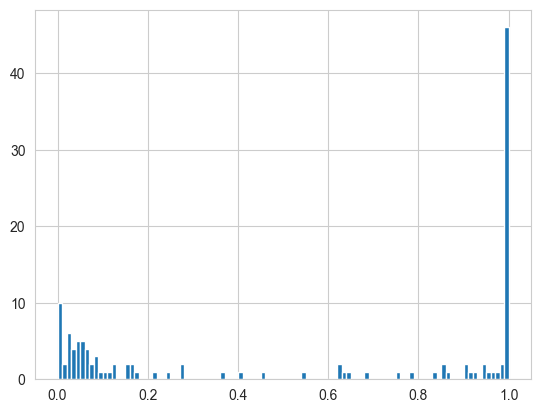

In [12]:
#REMOVE CORE CITIES HERE
percent_threshold = 0.6
city_types = ["Core City (London)", "Core City (outside London)", "Other City"]
df_cities = pd.read_csv("./lauth-classification-csv.csv")
df_cities.drop(df_cities[~df_cities["classification"].isin(city_types)].index, inplace=True)
df_cities = df_cities.groupby(["localauth_code"])["percent_of_localauth"].sum()
percents = df_cities.tolist()
n, bins, patches = plt.hist(percents, bins=100)

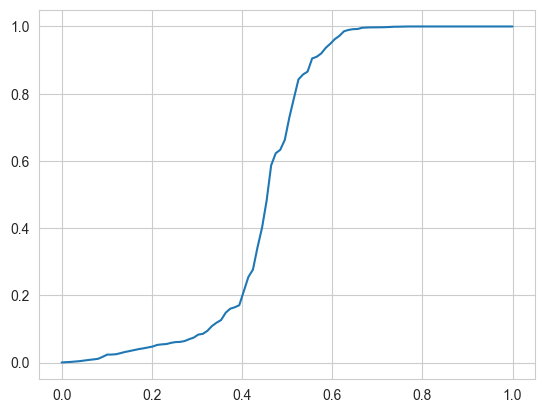

In [13]:
quantiles = np.quantile(percents, np.linspace(0, 1, 100))
plt.plot(np.linspace(0,1,100), quantiles)

In [14]:
#REMOVE CORE CITIES HERE
df_cities = df_cities[df_cities > percent_threshold]
df_merged_filtered_final = df_merged_final[~df_merged_final["Local Authority Code"].isin(list(df_cities.keys()))]
df_merged_filtered_final.reset_index(inplace=True, drop=True)

df_merged_filtered_final

,Local Authority Code,Local Authority_x,Region,Area (km2),ONS Area \nCode,Local Authority_y,All 'A' roads,Total road length,Count Sites
0,E08000022,North Tyneside,North East,84.8234,E08000022,North Tyneside,94.9,813.8,4
1,E06000001,Hartlepool,North East,98.3466,E06000001,Hartlepool UA,48.0,413.6,1
2,E08000004,Oldham,North West,142.3450,E08000004,Oldham,99.3,828.8,8
3,E08000037,Gateshead,North East,144.0797,E08000037,Gateshead,77.1,910.7,22
4,E08000005,Rochdale,North West,158.1283,E08000005,Rochdale,83.1,790.7,4
5,E08000029,Solihull,West Midlands,178.2821,E08000029,Solihull,60.2,887.2,4
6,E06000034,Thurrock,East of England,184.3180,E06000034,Thurrock UA,88.0,599.9,3
7,E06000005,Darlington,North East,197.4758,E06000005,Darlington UA,65.0,563.2,7
8,E06000040,Windsor and Maidenhead,South East,198.4272,E06000040,Windsor and Maidenhead UA,82.1,684.4,7
9,E06000012,North East Lincolnshire,Yorkshire and the Humber,202.6626,E06000012,North East Lincolnshire UA,88.1,660.1,4


In [15]:
df_sorted_authorities = df_merged_filtered_final.loc[(df_merged_filtered_final["Count Sites"]/(df_merged_filtered_final["All 'A' roads"].astype(float))).sort_values(ascending=False).index]
df_sorted_authorities.drop(columns=["ONS Area \nCode", "Local Authority_y", "Total road length "], inplace=True)
df_sorted_authorities.reset_index(inplace=True, drop=True)
df_sorted_authorities

,Local Authority Code,Local Authority_x,Region,Area (km2),All 'A' roads,Count Sites
0,E08000037,Gateshead,North East,144.0797,77.1,22
1,E08000036,Wakefield,Yorkshire and the Humber,338.6198,175.0,38
2,E06000061,North Northamptonshire,East Midlands,986.5947,327.8,59
3,E06000031,Peterborough,East of England,343.4379,124.9,14
4,E06000005,Darlington,North East,197.4758,65.0,7
5,E06000062,West Northamptonshire,East Midlands,1380.3956,376.8,40
6,E06000055,Bedford,East of England,476.4082,115.5,12
7,E06000004,Stockton-on-Tees,North East,209.7309,104.1,10
8,E06000040,Windsor and Maidenhead,South East,198.4272,82.1,7
9,E06000017,Rutland,East Midlands,393.7490,95.5,8


In [23]:
df_temp = df_sorted_authorities.drop(columns=["Region"])
df_temp[0:10].to_latex()

"\\begin{tabular}{lllrlr}\n\\toprule\n & Local Authority Code & Local Authority_x & Area (km2) & All 'A' roads & Count Sites \\\\\n\\midrule\n0 & E08000037 & Gateshead & 144.079700 & 77.1 & 22 \\\\\n1 & E08000036 & Wakefield & 338.619800 & 175.0 & 38 \\\\\n2 & E06000061 & North Northamptonshire & 986.594700 & 327.8 & 59 \\\\\n3 & E06000031 & Peterborough & 343.437900 & 124.9 & 14 \\\\\n4 & E06000005 & Darlington & 197.475800 & 65.0 & 7 \\\\\n5 & E06000062 & West Northamptonshire & 1380.395600 & 376.8 & 40 \\\\\n6 & E06000055 & Bedford & 476.408200 & 115.5 & 12 \\\\\n7 & E06000004 & Stockton-on-Tees & 209.730900 & 104.1 & 10 \\\\\n8 & E06000040 & Windsor and Maidenhead & 198.427200 & 82.1 & 7 \\\\\n9 & E06000017 & Rutland & 393.749000 & 95.5 & 8 \\\\\n\\bottomrule\n\\end{tabular}\n"

In [21]:
la_list = list(df_sorted_authorities["Local Authority Code"][0:10])
la_list

['E08000037',
 'E08000036',
 'E06000061',
 'E06000031',
 'E06000005',
 'E06000062',
 'E06000055',
 'E06000004',
 'E06000040',
 'E06000017']